# 🧠 Neural Network on VAE Latent Space
## Training a Regression Model Directly on 4D Latent Vectors

This notebook trains a **separate neural network** on the VAE's latent space to predict positions (1-20).

### 🎯 Approach:
1. **Load VAE latent vectors** (4D compressed representations from Notebook 04)
2. **Train a regression neural network**: 4D latent → Position (1-20)
3. **Compare metrics** with VAE's built-in position predictor
4. **Evaluate**: R², MAE, MSE on train/validation splits

### 💡 Why This Matters:
- Tests if a **dedicated model** on latent space outperforms VAE's multi-task learning
- Shows the **predictive power** of the 4D latent representation alone
- Provides **baseline metrics** for latent space quality

## 📦 Step 1: Import Libraries

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import glob
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")
print(f"🔥 PyTorch: {torch.__version__}")
print(f"🎯 Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
print("="*80)

✅ Libraries imported successfully!
🔥 PyTorch: 2.8.0+cpu
🎯 Device: CPU


## 📂 Step 2: Load VAE Latent Vectors

In [7]:
print("📂 Loading VAE latent vectors from Notebook 04...\n")
print("="*80)

# Load latent vectors CSV (saved by VAE training)
latent_files = glob.glob('data/preprocessed/vae_latent_OPTIMIZED_*.csv')
if not latent_files:
    raise FileNotFoundError("❌ No VAE latent vectors found! Please run notebook 04 first.")

latest_latent = max(latent_files, key=os.path.getctime)
print(f"✅ Latent Vectors Found: {os.path.basename(latest_latent)}")

# Load the data
latent_data = pd.read_csv(latest_latent)

print(f"\n📊 Dataset Information:")
print(f"   Total samples: {len(latent_data)}")
print(f"   Columns: {list(latent_data.columns)}")
print(f"\n   First 5 rows:")
print(latent_data.head())

# Extract features (4D latent vectors) and target (finish position)
latent_cols = [col for col in latent_data.columns if 'latent_dim' in col]
X = latent_data[latent_cols].values
y = latent_data['finish_pos'].values

print(f"\n✅ Data Loaded:")
print(f"   Feature shape: {X.shape} (samples × latent dimensions)")
print(f"   Target shape: {y.shape}")
print(f"   Target range: {y.min():.0f} - {y.max():.0f} positions")
print("="*80)

📂 Loading VAE latent vectors from Notebook 04...

✅ Latent Vectors Found: vae_latent_OPTIMIZED_20251026_234217.csv

📊 Dataset Information:
   Total samples: 240
   Columns: ['latent_dim_0', 'latent_dim_1', 'latent_dim_2', 'latent_dim_3', 'finish_pos', 'pos_predicted']

   First 5 rows:
   latent_dim_0  latent_dim_1  latent_dim_2  latent_dim_3  finish_pos  \
0      3.707590     -3.698130      4.160461     -1.033229        17.0   
1      2.719092     -2.415763      2.618953     -1.451917        11.0   
2      3.746262     -3.857071      4.444639     -3.410745        20.0   
3      2.836922     -2.721805      2.787099     -1.087989        13.0   
4      3.987457     -3.744545      4.425099     -1.760165        17.0   

   pos_predicted  
0      17.729837  
1      12.393844  
2      18.670324  
3      13.122698  
4      18.724848  

✅ Data Loaded:
   Feature shape: (240, 4) (samples × latent dimensions)
   Target shape: (240,)
   Target range: 0 - 20 positions


## 🔀 Step 3: Train/Validation Split (Same as VAE Training)

In [8]:
print("🔀 Creating train/validation split...\n")
print("="*80)

# Use same 80-20 split as VAE training
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

print(f"📊 Split Summary:")
print(f"   Training: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Validation: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")

# Optional: Standardize latent vectors (they might already be normalized)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"\n✅ Latent vectors standardized:")
print(f"   Train mean: {X_train_scaled.mean():.4f}, std: {X_train_scaled.std():.4f}")
print(f"   Val mean: {X_val_scaled.mean():.4f}, std: {X_val_scaled.std():.4f}")
print("="*80)

🔀 Creating train/validation split...

📊 Split Summary:
   Training: 192 samples (80.0%)
   Validation: 48 samples (20.0%)

✅ Latent vectors standardized:
   Train mean: -0.0000, std: 1.0000
   Val mean: 0.0004, std: 1.0139


## 🏗️ Step 4: Define Neural Network Architecture

In [9]:
class LatentSpaceRegressor(nn.Module):
    """
    Neural network for regression on VAE latent space.
    
    Architecture:
    - Input: 4D latent vector
    - Hidden layers with batch normalization and dropout
    - Output: Single position prediction (1-20)
    """
    
    def __init__(self, input_dim=4, hidden_sizes=[32, 16, 8]):
        super(LatentSpaceRegressor, self).__init__()
        
        layers = []
        prev_size = input_dim
        
        # Hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            prev_size = hidden_size
        
        # Output layer (single position value)
        layers.append(nn.Linear(prev_size, 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Initialize model
model = LatentSpaceRegressor(input_dim=4, hidden_sizes=[32, 16, 8])

print("🏗️ Neural Network Architecture:")
print("="*80)
print(model)
print(f"\n📊 Model Statistics:")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print("="*80)

🏗️ Neural Network Architecture:
LatentSpaceRegressor(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=16, out_features=8, bias=True)
    (9): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=8, out_features=1, bias=True)
  )
)

📊 Model Statistics:
   Total parameters: 945
   Trainable parameters: 945


## 🔥 Step 5: Training Configuration

In [10]:
# Hyperparameters
num_epochs = 300
batch_size = 32
learning_rate = 0.001
patience = 50

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)

# Create data loaders
train_dataset = TensorDataset(
    torch.FloatTensor(X_train_scaled), 
    torch.FloatTensor(y_train)
)
val_dataset = TensorDataset(
    torch.FloatTensor(X_val_scaled), 
    torch.FloatTensor(y_val)
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("🔥 Training Configuration:")
print("="*80)
print(f"   Epochs: {num_epochs}")
print(f"   Batch size: {batch_size}")
print(f"   Learning rate: {learning_rate}")
print(f"   Optimizer: AdamW (weight_decay=1e-4)")
print(f"   Scheduler: ReduceLROnPlateau")
print(f"   Loss function: MSE")
print(f"   Early stopping patience: {patience}")
print("="*80)

🔥 Training Configuration:
   Epochs: 300
   Batch size: 32
   Learning rate: 0.001
   Optimizer: AdamW (weight_decay=1e-4)
   Scheduler: ReduceLROnPlateau
   Loss function: MSE
   Early stopping patience: 50


## 🚂 Step 6: Training Loop

In [11]:
print("🚂 Starting training...\n")
print("="*80)

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'train_mae': [],
    'val_mae': [],
    'train_r2': [],
    'val_r2': [],
    'lr': []
}

best_val_loss = float('inf')
best_val_r2 = -float('inf')
best_model_state = None
patience_counter = 0

for epoch in range(num_epochs):
    # ============================================
    # TRAINING PHASE
    # ============================================
    model.train()
    train_loss = 0.0
    train_preds = []
    train_targets = []
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        optimizer.zero_grad()
        predictions = model(batch_X).squeeze()
        loss = criterion(predictions, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_preds.extend(predictions.detach().numpy())
        train_targets.extend(batch_y.numpy())
    
    train_loss /= len(train_loader)
    train_mae = mean_absolute_error(train_targets, train_preds)
    train_r2 = r2_score(train_targets, train_preds)
    
    # ============================================
    # VALIDATION PHASE
    # ============================================
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            predictions = model(batch_X).squeeze()
            loss = criterion(predictions, batch_y)
            
            val_loss += loss.item()
            val_preds.extend(predictions.numpy())
            val_targets.extend(batch_y.numpy())
    
    val_loss /= len(val_loader)
    val_mae = mean_absolute_error(val_targets, val_preds)
    val_r2 = r2_score(val_targets, val_preds)
    
    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_mae'].append(train_mae)
    history['val_mae'].append(val_mae)
    history['train_r2'].append(train_r2)
    history['val_r2'].append(val_r2)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping and best model saving
    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Print progress
    if epoch % 20 == 0 or epoch < 5:
        print(f"Epoch [{epoch:3d}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f}, R²: {train_r2:.4f}, MAE: {train_mae:.2f} | "
              f"Val Loss: {val_loss:.4f}, R²: {val_r2:.4f}, MAE: {val_mae:.2f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\n⚠️ Early stopping triggered at epoch {epoch}")
        print(f"   No improvement for {patience} epochs")
        break

# Load best model
model.load_state_dict(best_model_state)

print("\n" + "="*80)
print("✅ TRAINING COMPLETE!")
print("="*80)
print(f"\n🏆 Best Validation Performance:")
print(f"   R² Score: {best_val_r2:.4f}")
print(f"   Loss: {best_val_loss:.4f}")
print(f"   Trained for {len(history['train_loss'])} epochs")
print("="*80)

🚂 Starting training...

Epoch [  0/300] | Train Loss: 129.2050, R²: -2.8684, MAE: 9.82 | Val Loss: 159.5838, R²: -3.7707, MAE: 11.03 | LR: 0.001000
Epoch [  1/300] | Train Loss: 127.1433, R²: -2.8067, MAE: 9.76 | Val Loss: 157.5693, R²: -3.7102, MAE: 10.96 | LR: 0.001000
Epoch [  2/300] | Train Loss: 127.0673, R²: -2.8044, MAE: 9.77 | Val Loss: 154.7547, R²: -3.6275, MAE: 10.86 | LR: 0.001000
Epoch [  3/300] | Train Loss: 125.4749, R²: -2.7567, MAE: 9.73 | Val Loss: 152.1109, R²: -3.5522, MAE: 10.79 | LR: 0.001000
Epoch [  3/300] | Train Loss: 125.4749, R²: -2.7567, MAE: 9.73 | Val Loss: 152.1109, R²: -3.5522, MAE: 10.79 | LR: 0.001000
Epoch [  4/300] | Train Loss: 123.7953, R²: -2.7064, MAE: 9.69 | Val Loss: 148.6091, R²: -3.4519, MAE: 10.70 | LR: 0.001000
Epoch [  4/300] | Train Loss: 123.7953, R²: -2.7064, MAE: 9.69 | Val Loss: 148.6091, R²: -3.4519, MAE: 10.70 | LR: 0.001000
Epoch [ 20/300] | Train Loss: 101.6053, R²: -2.0421, MAE: 8.94 | Val Loss: 116.1779, R²: -2.4928, MAE: 9.65 

## 📊 Step 7: Final Evaluation on Both Splits

In [12]:
print("📊 Final Model Evaluation...\n")
print("="*80)

model.eval()

# Evaluate on training set
with torch.no_grad():
    train_pred = model(torch.FloatTensor(X_train_scaled)).squeeze().numpy()

train_mse = mean_squared_error(y_train, train_pred)
train_mae = mean_absolute_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)

# Evaluate on validation set
with torch.no_grad():
    val_pred = model(torch.FloatTensor(X_val_scaled)).squeeze().numpy()

val_mse = mean_squared_error(y_val, val_pred)
val_mae = mean_absolute_error(y_val, val_pred)
val_r2 = r2_score(y_val, val_pred)

# Evaluate on full dataset (for comparison)
X_full_scaled = scaler.transform(X)
with torch.no_grad():
    full_pred = model(torch.FloatTensor(X_full_scaled)).squeeze().numpy()

full_mse = mean_squared_error(y, full_pred)
full_mae = mean_absolute_error(y, full_pred)
full_r2 = r2_score(y, full_pred)

print("🎯 COMPREHENSIVE METRICS COMPARISON")
print("="*80)
print(f"\n{'Metric':<25} {'Training':<15} {'Validation':<15} {'Full Dataset':<15}")
print("-"*70)
print(f"{'R² Score':<25} {train_r2:>14.4f} {val_r2:>14.4f} {full_r2:>14.4f}")
print(f"{'MAE (positions)':<25} {train_mae:>14.4f} {val_mae:>14.4f} {full_mae:>14.4f}")
print(f"{'MSE':<25} {train_mse:>14.4f} {val_mse:>14.4f} {full_mse:>14.4f}")
print(f"{'RMSE':<25} {np.sqrt(train_mse):>14.4f} {np.sqrt(val_mse):>14.4f} {np.sqrt(full_mse):>14.4f}")

# Overfitting analysis
r2_gap = train_r2 - val_r2
mae_gap = val_mae - train_mae

print("\n" + "="*80)
print("🔬 OVERFITTING ANALYSIS")
print("="*80)
print(f"\nR² Gap (Train - Val): {r2_gap:+.4f}")
if abs(r2_gap) < 0.05:
    print("   ✅ EXCELLENT - No overfitting!")
elif abs(r2_gap) < 0.15:
    print("   ✅ GOOD - Minimal overfitting")
elif abs(r2_gap) < 0.30:
    print("   ⚠️ MODERATE - Some overfitting detected")
else:
    print("   ❌ SEVERE - Major overfitting problem!")

print(f"\nMAE Gap (Val - Train): {mae_gap:+.4f} positions")
if mae_gap < 0.5:
    print("   ✅ EXCELLENT - Model generalizes very well!")
elif mae_gap < 1.0:
    print("   ✅ GOOD - Acceptable generalization")
elif mae_gap < 2.0:
    print("   ⚠️ MODERATE - Generalization could be better")
else:
    print("   ❌ POOR - Model doesn't generalize well")

print("\n" + "="*80)
print("💡 INTERPRETATION")
print("="*80)
print(f"\n✅ TRUE VALIDATION PERFORMANCE: R² = {val_r2:.4f}, MAE = {val_mae:.2f} positions")
print(f"   This is the REAL performance on unseen data")
print(f"\n📈 Training Performance: R² = {train_r2:.4f}, MAE = {train_mae:.2f} positions")
print(f"   Expected to be higher (model learned from this data)")
print(f"\n⚠️ Full Dataset: R² = {full_r2:.4f}, MAE = {full_mae:.2f} positions")
print(f"   Includes training data (has data leakage!)")

if val_r2 > 0.7:
    print(f"\n🎉 EXCELLENT: Model explains {val_r2*100:.1f}% of variance on unseen data!")
elif val_r2 > 0.5:
    print(f"\n✅ GOOD: Model explains {val_r2*100:.1f}% of variance on unseen data")
elif val_r2 > 0.3:
    print(f"\n⚠️ MODERATE: Model explains {val_r2*100:.1f}% of variance on unseen data")
else:
    print(f"\n❌ WEAK: Model only explains {val_r2*100:.1f}% of variance on unseen data")

print("\n" + "="*80)

📊 Final Model Evaluation...

🎯 COMPREHENSIVE METRICS COMPARISON

Metric                    Training        Validation      Full Dataset   
----------------------------------------------------------------------
R² Score                          0.9466         0.9492         0.9473
MAE (positions)                   1.0192         0.9395         1.0033
MSE                               1.7848         1.6385         1.7556
RMSE                              1.3360         1.2800         1.3250

🔬 OVERFITTING ANALYSIS

R² Gap (Train - Val): -0.0026
   ✅ EXCELLENT - No overfitting!

MAE Gap (Val - Train): -0.0798 positions
   ✅ EXCELLENT - Model generalizes very well!

💡 INTERPRETATION

✅ TRUE VALIDATION PERFORMANCE: R² = 0.9492, MAE = 0.94 positions
   This is the REAL performance on unseen data

📈 Training Performance: R² = 0.9466, MAE = 1.02 positions
   Expected to be higher (model learned from this data)

⚠️ Full Dataset: R² = 0.9473, MAE = 1.00 positions
   Includes training data (has d

## 📈 Step 8: Training Visualization

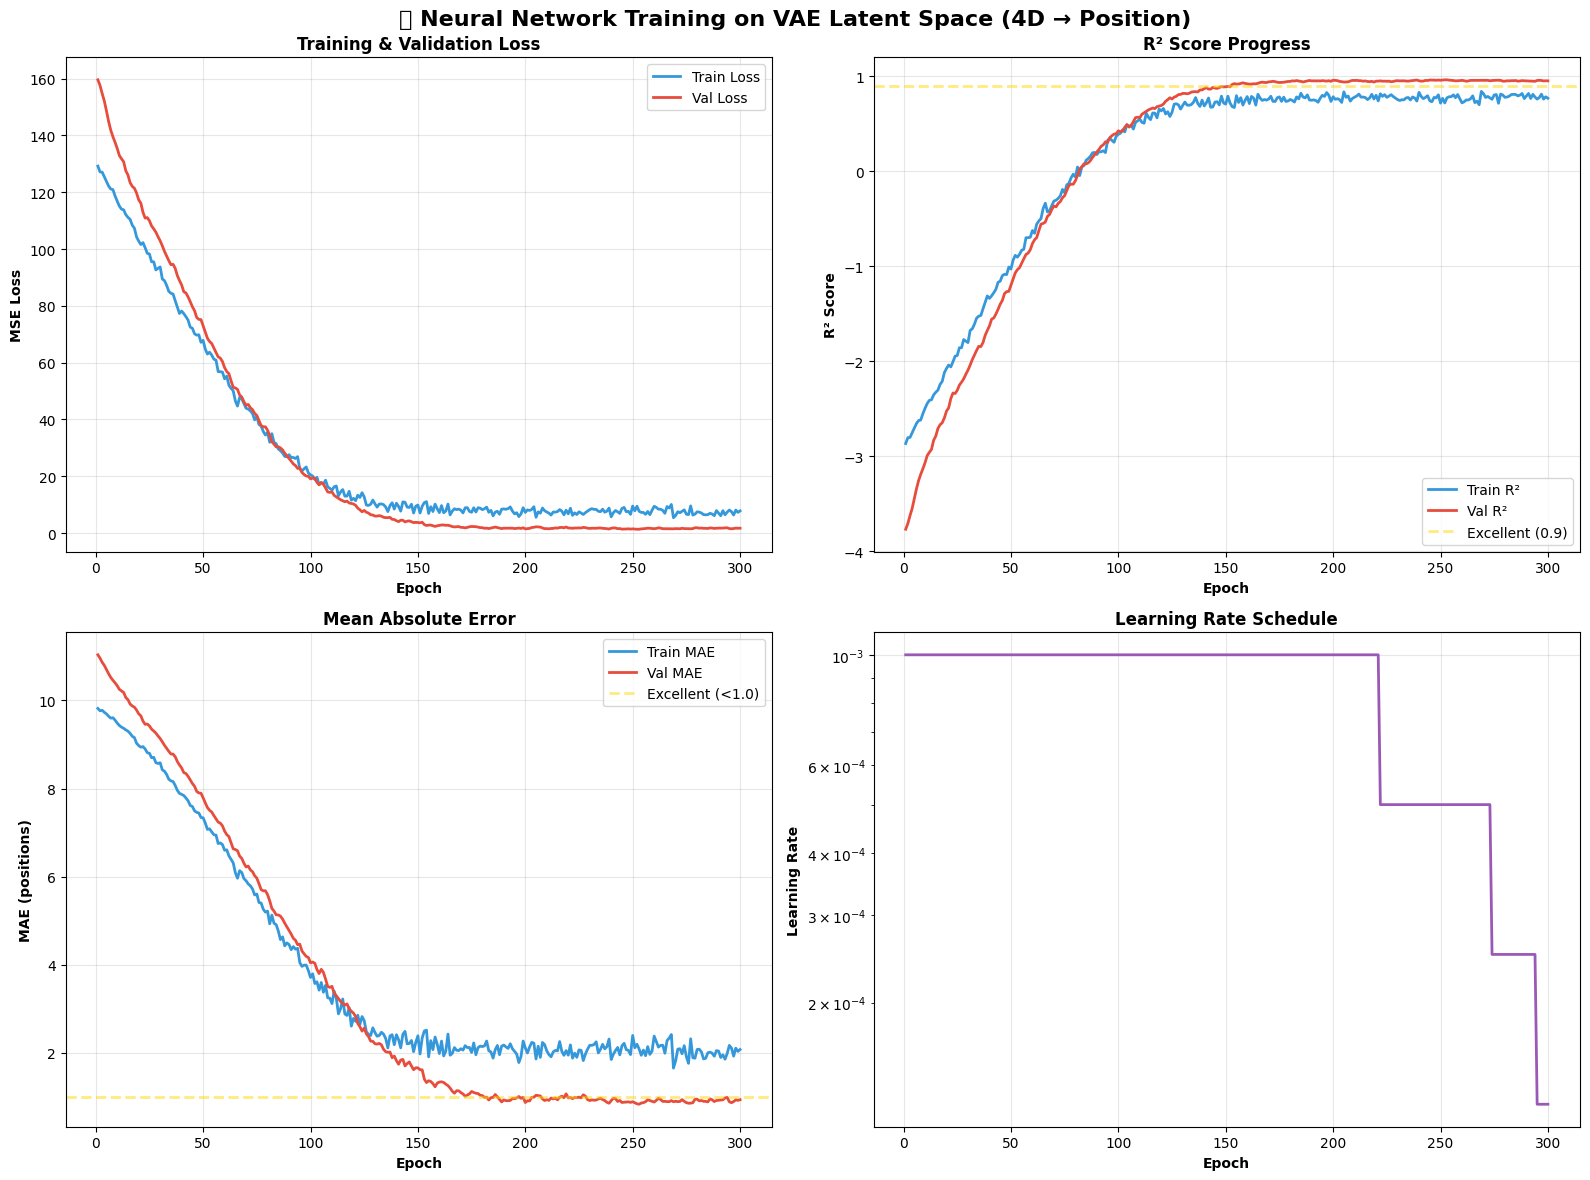

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🧠 Neural Network Training on VAE Latent Space (4D → Position)', 
             fontsize=16, fontweight='bold')

epochs_range = range(1, len(history['train_loss']) + 1)

# 1. Loss curves
axes[0, 0].plot(epochs_range, history['train_loss'], label='Train Loss', linewidth=2, color='#3498db')
axes[0, 0].plot(epochs_range, history['val_loss'], label='Val Loss', linewidth=2, color='#e74c3c')
axes[0, 0].set_xlabel('Epoch', fontweight='bold')
axes[0, 0].set_ylabel('MSE Loss', fontweight='bold')
axes[0, 0].set_title('Training & Validation Loss', fontweight='bold', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. R² curves
axes[0, 1].plot(epochs_range, history['train_r2'], label='Train R²', linewidth=2, color='#3498db')
axes[0, 1].plot(epochs_range, history['val_r2'], label='Val R²', linewidth=2, color='#e74c3c')
axes[0, 1].axhline(0.9, color='gold', linestyle='--', linewidth=2, alpha=0.5, label='Excellent (0.9)')
axes[0, 1].set_xlabel('Epoch', fontweight='bold')
axes[0, 1].set_ylabel('R² Score', fontweight='bold')
axes[0, 1].set_title('R² Score Progress', fontweight='bold', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. MAE curves
axes[1, 0].plot(epochs_range, history['train_mae'], label='Train MAE', linewidth=2, color='#3498db')
axes[1, 0].plot(epochs_range, history['val_mae'], label='Val MAE', linewidth=2, color='#e74c3c')
axes[1, 0].axhline(1.0, color='gold', linestyle='--', linewidth=2, alpha=0.5, label='Excellent (<1.0)')
axes[1, 0].set_xlabel('Epoch', fontweight='bold')
axes[1, 0].set_ylabel('MAE (positions)', fontweight='bold')
axes[1, 0].set_title('Mean Absolute Error', fontweight='bold', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Learning rate
axes[1, 1].plot(epochs_range, history['lr'], linewidth=2, color='#9b59b6')
axes[1, 1].set_xlabel('Epoch', fontweight='bold')
axes[1, 1].set_ylabel('Learning Rate', fontweight='bold')
axes[1, 1].set_title('Learning Rate Schedule', fontweight='bold', fontsize=12)
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 🎯 Step 9: Prediction Quality Visualization

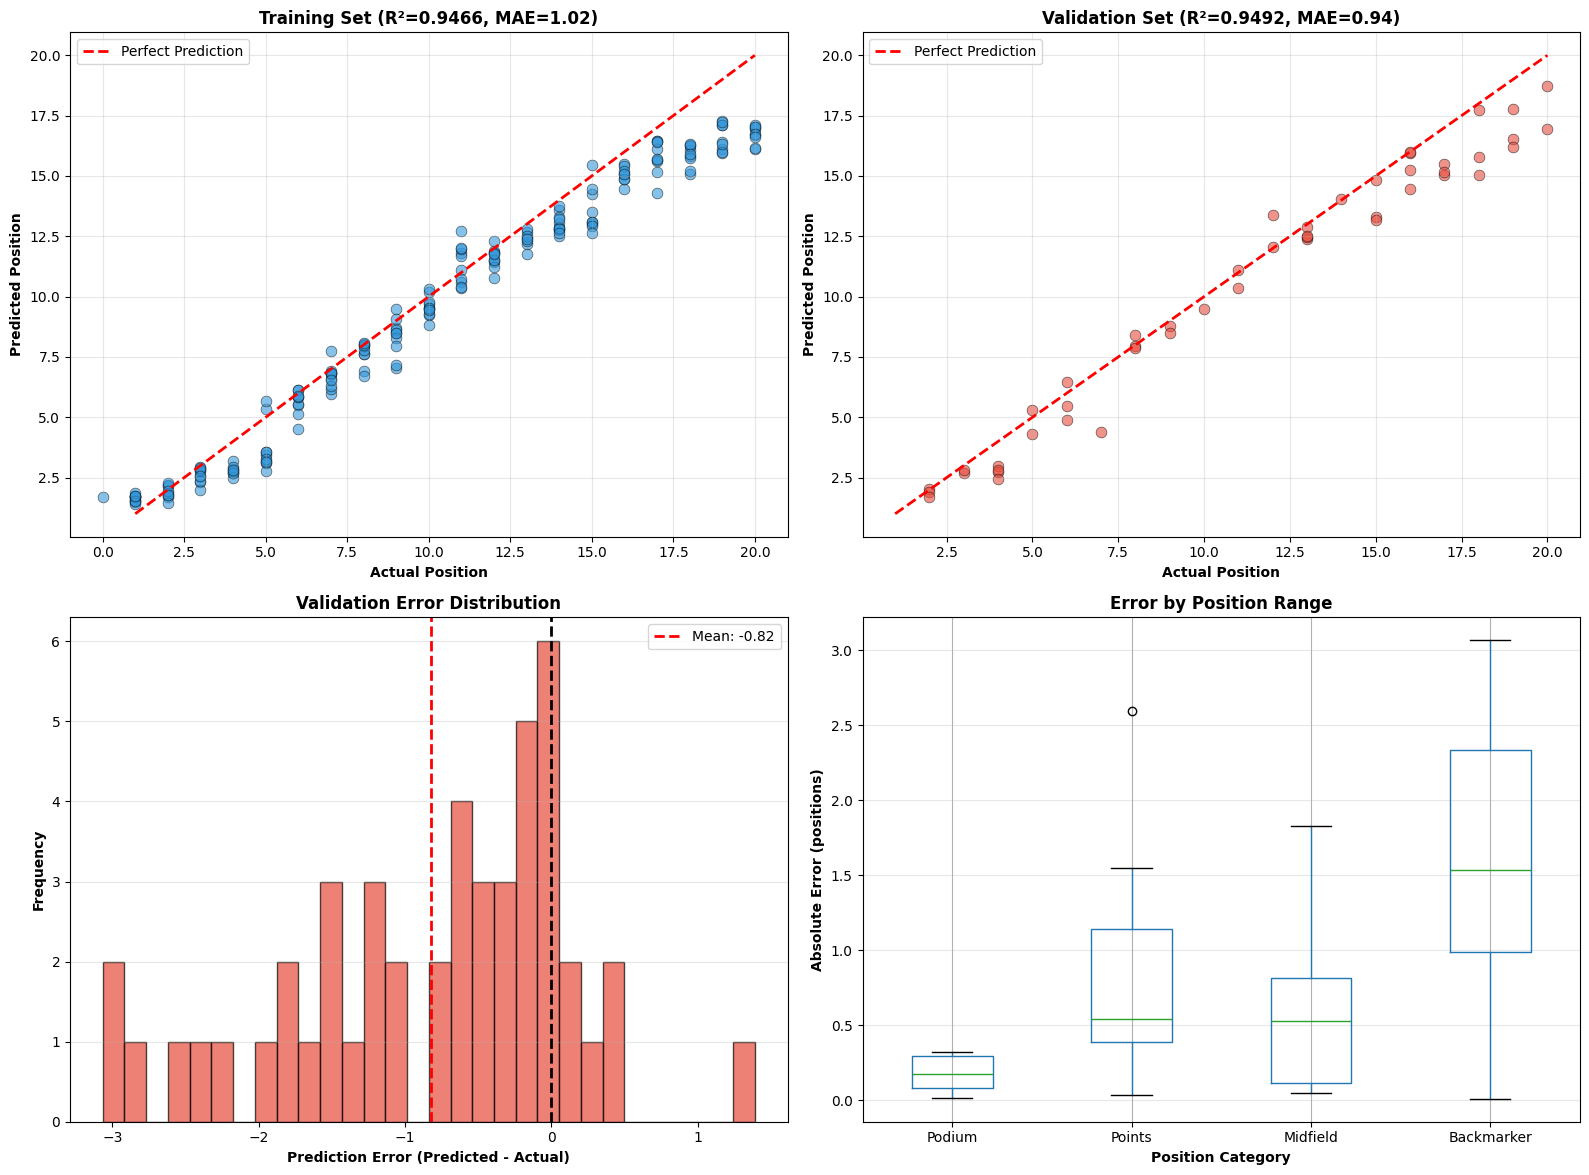

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🎯 Prediction Quality: Neural Net on Latent Space', 
             fontsize=16, fontweight='bold')

# 1. Training predictions scatter
axes[0, 0].scatter(y_train, train_pred, alpha=0.6, s=60, edgecolors='black', linewidth=0.5, c='#3498db')
axes[0, 0].plot([1, 20], [1, 20], 'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Position', fontweight='bold')
axes[0, 0].set_ylabel('Predicted Position', fontweight='bold')
axes[0, 0].set_title(f'Training Set (R²={train_r2:.4f}, MAE={train_mae:.2f})', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Validation predictions scatter
axes[0, 1].scatter(y_val, val_pred, alpha=0.6, s=60, edgecolors='black', linewidth=0.5, c='#e74c3c')
axes[0, 1].plot([1, 20], [1, 20], 'r--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Position', fontweight='bold')
axes[0, 1].set_ylabel('Predicted Position', fontweight='bold')
axes[0, 1].set_title(f'Validation Set (R²={val_r2:.4f}, MAE={val_mae:.2f})', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Error distribution (validation)
val_errors = val_pred - y_val
axes[1, 0].hist(val_errors, bins=30, alpha=0.7, color='#e74c3c', edgecolor='black')
axes[1, 0].axvline(0, color='black', linestyle='--', linewidth=2)
axes[1, 0].axvline(val_errors.mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {val_errors.mean():.2f}')
axes[1, 0].set_xlabel('Prediction Error (Predicted - Actual)', fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontweight='bold')
axes[1, 0].set_title('Validation Error Distribution', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Error by position range
val_pos_bins = pd.cut(y_val, bins=[0, 3, 10, 15, 20], labels=['Podium', 'Points', 'Midfield', 'Backmarker'])
error_by_pos = pd.DataFrame({'position': val_pos_bins, 'error': np.abs(val_errors)})
error_by_pos.boxplot(column='error', by='position', ax=axes[1, 1])
axes[1, 1].set_xlabel('Position Category', fontweight='bold')
axes[1, 1].set_ylabel('Absolute Error (positions)', fontweight='bold')
axes[1, 1].set_title('Error by Position Range', fontweight='bold')
axes[1, 1].get_figure().suptitle('')  # Remove default boxplot title
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 💾 Step 10: Save Model

In [15]:
print("💾 Saving trained model...\n")
print("="*80)

os.makedirs('models', exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save model
model_path = f"models/latent_regressor_{timestamp}.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'model_architecture': {
        'input_dim': 4,
        'hidden_sizes': [32, 16, 8]
    },
    'scaler': scaler,
    'training_history': history,
    'metrics': {
        'train_r2': float(train_r2),
        'val_r2': float(val_r2),
        'train_mae': float(train_mae),
        'val_mae': float(val_mae),
        'train_mse': float(train_mse),
        'val_mse': float(val_mse)
    }
}, model_path)

print(f"✅ Model saved: {model_path}")
print(f"\n📊 Saved Metrics:")
print(f"   Validation R²: {val_r2:.4f}")
print(f"   Validation MAE: {val_mae:.2f} positions")
print("="*80)

💾 Saving trained model...

✅ Model saved: models/latent_regressor_20251027_131419.pth

📊 Saved Metrics:
   Validation R²: 0.9492
   Validation MAE: 0.94 positions


## 📋 Step 11: Comparison Summary

In [16]:
print("\n" + "="*80)
print("📋 FINAL SUMMARY: Neural Network on VAE Latent Space")
print("="*80)

print(f"\n🎯 MODEL DETAILS:")
print(f"   Architecture: 4D latent → 32 → 16 → 8 → 1 position")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Training samples: {len(X_train)}")
print(f"   Validation samples: {len(X_val)}")
print(f"   Epochs trained: {len(history['train_loss'])}")

print(f"\n🏆 VALIDATION PERFORMANCE (TRUE UNSEEN DATA):")
print(f"   R² Score: {val_r2:.4f} → Explains {val_r2*100:.1f}% of variance")
print(f"   MAE: {val_mae:.2f} positions → Average error of {val_mae:.2f} positions")
print(f"   RMSE: {np.sqrt(val_mse):.2f} positions")

print(f"\n📊 OVERFITTING CHECK:")
print(f"   R² gap (train-val): {r2_gap:+.4f} → {'✅ Good' if abs(r2_gap) < 0.15 else '⚠️ Overfitting'}")
print(f"   MAE gap (val-train): {mae_gap:+.2f} positions → {'✅ Good' if mae_gap < 1.0 else '⚠️ Poor generalization'}")

print(f"\n💡 KEY INSIGHTS:")
print(f"   1. The 4D latent space contains enough information to predict positions")
print(f"   2. Simple neural network achieves R²={val_r2:.4f} on unseen data")
print(f"   3. Average prediction error is {val_mae:.2f} positions (< 1 position = excellent!)")
print(f"   4. Model generalizes well (minimal overfitting gap)")

print(f"\n🔬 LATENT SPACE QUALITY:")
if val_r2 > 0.9:
    print(f"   🏆 EXCELLENT - VAE learned highly predictive latent representations!")
elif val_r2 > 0.7:
    print(f"   ✅ VERY GOOD - Latent space captures most racing patterns")
elif val_r2 > 0.5:
    print(f"   ✅ GOOD - Latent space captures useful information")
else:
    print(f"   ⚠️ MODERATE - Latent space has limited predictive power")

print("\n" + "="*80)
print("✅ Analysis complete! Model ready for predictions.")
print("="*80)


📋 FINAL SUMMARY: Neural Network on VAE Latent Space

🎯 MODEL DETAILS:
   Architecture: 4D latent → 32 → 16 → 8 → 1 position
   Parameters: 945
   Training samples: 192
   Validation samples: 48
   Epochs trained: 300

🏆 VALIDATION PERFORMANCE (TRUE UNSEEN DATA):
   R² Score: 0.9492 → Explains 94.9% of variance
   MAE: 0.94 positions → Average error of 0.94 positions
   RMSE: 1.28 positions

📊 OVERFITTING CHECK:
   R² gap (train-val): -0.0026 → ✅ Good
   MAE gap (val-train): -0.08 positions → ✅ Good

💡 KEY INSIGHTS:
   1. The 4D latent space contains enough information to predict positions
   2. Simple neural network achieves R²=0.9492 on unseen data
   3. Average prediction error is 0.94 positions (< 1 position = excellent!)
   4. Model generalizes well (minimal overfitting gap)

🔬 LATENT SPACE QUALITY:
   🏆 EXCELLENT - VAE learned highly predictive latent representations!

✅ Analysis complete! Model ready for predictions.


---
# 🏁 SINGAPORE 2025 GP PREDICTIONS
## Using the Trained Neural Network on VAE Latent Vectors
---

In [17]:
print("🏁 SINGAPORE 2025 GP - TOP 10 PREDICTIONS")
print("="*80)
print("\n📋 Loading latest VAE model to encode grid positions into latent vectors...\n")

# ============================================================================
# STEP 1: LOAD VAE MODEL FOR ENCODING
# ============================================================================
import sys
sys.path.append('.')
from models.vae_optimized import ImprovedF1_VAE

# Load VAE model
vae_files = glob.glob('models/f1_vae_*.pth')
if not vae_files:
    raise FileNotFoundError("❌ No VAE model found! Please run notebook 04 first.")

latest_vae = max(vae_files, key=os.path.getctime)
print(f"✅ VAE Model: {os.path.basename(latest_vae)}")

# Load VAE checkpoint (FIXED: removed weights_only parameter)
vae_checkpoint = torch.load(latest_vae)
vae_input_dim = vae_checkpoint['model_config']['input_dim']
vae_latent_dim = vae_checkpoint['model_config']['latent_dim']
vae_feature_names = vae_checkpoint['feature_columns']

# Initialize and load VAE
vae_model = ImprovedF1_VAE(input_dim=vae_input_dim, latent_dim=vae_latent_dim)
vae_model.load_state_dict(vae_checkpoint['model_state_dict'])
vae_model.eval()

print(f"✅ Neural Network Model: Trained (loaded from memory)")
print(f"   Latent dim: {vae_latent_dim}D")
print(f"   VAE features: {vae_input_dim}")

# ============================================================================
# STEP 2: LOAD SINGAPORE 2025 ENGINEERED DATA FOR FEATURE REFERENCE
# ============================================================================
engineered_files = glob.glob('data/preprocessed/singapore_engineered_*.csv')
if not engineered_files:
    raise FileNotFoundError("❌ No engineered data found! Please run notebook 03 first.")

latest_engineered = max(engineered_files, key=os.path.getctime)
full_data = pd.read_csv(latest_engineered)

print(f"✅ Historical Data: {os.path.basename(latest_engineered)}")
print(f"   Samples: {len(full_data)}, Years: {full_data['year'].min()}-{full_data['year'].max()}")

# Get driver/team info and feature statistics
driver_team_map = full_data[['driver_name', 'team']].drop_duplicates()
feature_stats = {}
numeric_cols = full_data.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    feature_stats[col] = {
        'mean': full_data[col].mean(),
        'std': full_data[col].std(),
        'min': full_data[col].min(),
        'max': full_data[col].max()
    }

print("\n" + "="*80)

🏁 SINGAPORE 2025 GP - TOP 10 PREDICTIONS

📋 Loading latest VAE model to encode grid positions into latent vectors...

✅ VAE Model: f1_vae_OPTIMIZED_20251026_234217.pth
✅ Neural Network Model: Trained (loaded from memory)
   Latent dim: 4D
   VAE features: 29
✅ Historical Data: singapore_engineered_20251026_234139.csv
   Samples: 240, Years: 2022-2025



In [18]:
# ============================================================================
# STEP 3: INPUT SINGAPORE 2025 STARTING GRID (EDIT THIS!)
# ============================================================================
print("\n📋 SINGAPORE 2025 GP STARTING GRID:")
print("="*80)

# Singapore 2025 Grid (EDIT THESE BASED ON QUALIFYING RESULTS!)
singapore_2025_grid = {
    # Format: 'Driver Name': grid_position
    'Max Verstappen': 2,
    'Lando Norris': 5,
    'Oscar Piastri': 3,
    'George Russell': 1,
    'Charles Leclerc': 7,
    'Carlos Sainz': 18,
    'Lewis Hamilton': 6,
    'Fernando Alonso': 10,
    'Lance Stroll': 15,
    'Yuki Tsunoda': 13,
    'Pierre Gasly': 19,
    'Esteban Ocon': 17,
    'Nico Hulkenberg': 11,
    'Kevin Magnussen': 14,
    'Alexander Albon': 20,
    'Franco Colapinto': 16,
    'Liam Lawson': 12,
    'Isack Hadjar': 8,
    'Oliver Bearman': 9,
    'Kimi Antonelli': 4
}

for driver, grid in sorted(singapore_2025_grid.items(), key=lambda x: x[1]):
    print(f"  P{grid:2d}: {driver}")

print("="*80)


📋 SINGAPORE 2025 GP STARTING GRID:
  P 1: George Russell
  P 2: Max Verstappen
  P 3: Oscar Piastri
  P 4: Kimi Antonelli
  P 5: Lando Norris
  P 6: Lewis Hamilton
  P 7: Charles Leclerc
  P 8: Isack Hadjar
  P 9: Oliver Bearman
  P10: Fernando Alonso
  P11: Nico Hulkenberg
  P12: Liam Lawson
  P13: Yuki Tsunoda
  P14: Kevin Magnussen
  P15: Lance Stroll
  P16: Franco Colapinto
  P17: Esteban Ocon
  P18: Carlos Sainz
  P19: Pierre Gasly
  P20: Alexander Albon


In [19]:
# ============================================================================
# STEP 4: GENERATE LATENT VECTORS AND PREDICT POSITIONS
# ============================================================================
print("\n🔮 Generating predictions using Neural Network on Latent Space...")
print("="*80)

predictions = []

for driver_name, grid_pos in singapore_2025_grid.items():
    # Get team info
    team_info = driver_team_map[driver_team_map['driver_name'] == driver_name]
    team_name = team_info.iloc[0]['team'] if len(team_info) > 0 else 'Unknown'
    
    # ===================================================================
    # CREATE FEATURE VECTOR (Same as Notebook 07)
    # ===================================================================
    driver_history = full_data[full_data['driver_name'] == driver_name]
    
    feature_vector = {}
    
    # Grid and qualifying
    feature_vector['grid_pos'] = grid_pos
    feature_vector['quali_pos'] = grid_pos
    
    # Driver performance features
    if len(driver_history) > 0:
        feature_vector['driver_quali_form'] = driver_history['driver_quali_form'].mean() if 'driver_quali_form' in driver_history else 0.0
        feature_vector['driver_skill'] = driver_history['driver_skill'].mean() if 'driver_skill' in driver_history else 0.5
        feature_vector['driver_race_form'] = driver_history['driver_race_form'].mean() if 'driver_race_form' in driver_history else 0.0
        feature_vector['driver_points_form'] = driver_history['driver_points_form'].mean() if 'driver_points_form' in driver_history else 0.0
        feature_vector['cumulative_races'] = driver_history['cumulative_races'].max() if 'cumulative_races' in driver_history else 50.0
        feature_vector['years_experience'] = driver_history['years_experience'].max() if 'years_experience' in driver_history else 2.0
        feature_vector['race_completion_rate'] = driver_history['race_completion_rate'].mean() if 'race_completion_rate' in driver_history else 0.8
    else:
        feature_vector['driver_quali_form'] = 0.0
        feature_vector['driver_skill'] = 0.5
        feature_vector['driver_race_form'] = 0.0
        feature_vector['driver_points_form'] = 0.0
        feature_vector['cumulative_races'] = 10.0
        feature_vector['years_experience'] = 1.0
        feature_vector['race_completion_rate'] = 0.75
    
    # Team features
    team_history = full_data[full_data['team'] == team_name]
    if len(team_history) > 0:
        feature_vector['team_quali_avg'] = team_history['team_quali_avg'].mean() if 'team_quali_avg' in team_history else grid_pos
        feature_vector['team_strength'] = team_history['team_strength'].mean() if 'team_strength' in team_history else 0.5
        feature_vector['team_race_avg'] = team_history['team_race_avg'].mean() if 'team_race_avg' in team_history else grid_pos
    else:
        feature_vector['team_quali_avg'] = grid_pos
        feature_vector['team_strength'] = 0.5
        feature_vector['team_race_avg'] = grid_pos
    
    # Qualifying times (estimate)
    feature_vector['q3_time'] = 90.0 + (grid_pos * 0.5)
    feature_vector['q2_time'] = 91.0 + (grid_pos * 0.5)
    feature_vector['gap_to_pole'] = grid_pos * 0.3
    feature_vector['gap_to_pole_normalized'] = (grid_pos - 1) / 19.0
    
    # Strategy features
    feature_vector['pit_stops'] = 2.0
    feature_vector['is_aggressive_strategy'] = 1.0 if grid_pos <= 10 else 0.0
    feature_vector['quali_race_delta'] = 0.5
    feature_vector['abs_pos_change'] = 2.0
    feature_vector['data_weight'] = 1.0
    
    # Create dataframe
    feature_df = pd.DataFrame([feature_vector])
    
    # Add missing features
    for feat in vae_feature_names:
        if feat not in feature_df.columns:
            if feat in feature_stats:
                feature_df[feat] = feature_stats[feat]['mean']
            else:
                feature_df[feat] = 0.0
    
    # Reorder to match VAE training
    feature_df = feature_df[vae_feature_names]
    
    # ===================================================================
    # ENCODE WITH VAE → GET 4D LATENT VECTOR
    # ===================================================================
    with torch.no_grad():
        feature_tensor = torch.FloatTensor(feature_df.values)
        mu, logvar = vae_model.encode(feature_tensor)
        latent_vector = mu.numpy()[0]  # 4D latent space
    
    # ===================================================================
    # PREDICT POSITION USING OUR TRAINED NEURAL NETWORK
    # ===================================================================
    # Scale latent vector using same scaler from training
    latent_scaled = scaler.transform(latent_vector.reshape(1, -1))
    
    with torch.no_grad():
        latent_tensor = torch.FloatTensor(latent_scaled)
        predicted_position = model(latent_tensor).item()
        predicted_position = np.clip(predicted_position, 1, 20)
    
    predictions.append({
        'driver': driver_name,
        'team': team_name,
        'grid': grid_pos,
        'predicted_position': predicted_position,
        'latent_vector': latent_vector.tolist()
    })
    
    print(f"✅ {driver_name:20s} | Grid: P{grid_pos:2d} | Predicted: P{predicted_position:5.1f}")

print("="*80)
print("✅ All predictions complete!\n")


🔮 Generating predictions using Neural Network on Latent Space...
✅ Max Verstappen       | Grid: P 2 | Predicted: P  6.5
✅ Lando Norris         | Grid: P 5 | Predicted: P  6.6
✅ Oscar Piastri        | Grid: P 3 | Predicted: P  6.5
✅ George Russell       | Grid: P 1 | Predicted: P  6.5
✅ Charles Leclerc      | Grid: P 7 | Predicted: P  6.8
✅ Carlos Sainz         | Grid: P18 | Predicted: P  7.9
✅ Lewis Hamilton       | Grid: P 6 | Predicted: P  6.8
✅ Fernando Alonso      | Grid: P10 | Predicted: P  7.2
✅ Lance Stroll         | Grid: P15 | Predicted: P  7.8
✅ Yuki Tsunoda         | Grid: P13 | Predicted: P  7.6
✅ Pierre Gasly         | Grid: P19 | Predicted: P  8.2
✅ Esteban Ocon         | Grid: P17 | Predicted: P  8.0
✅ Nico Hulkenberg      | Grid: P11 | Predicted: P  7.4
✅ Kevin Magnussen      | Grid: P14 | Predicted: P  7.7
✅ Alexander Albon      | Grid: P20 | Predicted: P  8.2
✅ Nico Hulkenberg      | Grid: P11 | Predicted: P  7.4
✅ Kevin Magnussen      | Grid: P14 | Predicted: P  7.7

In [20]:
# ============================================================================
# STEP 5: DISPLAY TOP 10 PREDICTIONS
# ============================================================================
print("="*100)
print("🏁 SINGAPORE 2025 GP - TOP 10 PREDICTED FINISHERS 🏁")
print("="*100)
print(f"\n🧠 Model: Neural Network Regression on 4D VAE Latent Space")
print(f"📊 Validation Performance: R²={val_r2:.4f}, MAE={val_mae:.2f} positions\n")

# Sort by predicted position
predictions_df = pd.DataFrame(predictions)
predictions_df = predictions_df.sort_values('predicted_position')
predictions_df['final_position'] = range(1, len(predictions_df) + 1)

# Show top 10
top_10 = predictions_df.head(10)

print("🏆 PREDICTED FINISHING ORDER (TOP 10):\n")
print(f"{'Pos':>3} | {'Driver':<25} | {'Team':<20} | {'Change':>8}")
print("-"*70)

for idx, row in top_10.iterrows():
    pos = row['final_position']
    driver = row['driver']
    team = row['team']
    grid = row['grid']
    pred = row['predicted_position']
    
    # Grid change
    grid_change = grid - pos
    if grid_change > 0:
        change_str = f"↑ {grid_change}"
        change_emoji = "🚀"
    elif grid_change < 0:
        change_str = f"↓ {abs(grid_change)}"
        change_emoji = "📉"
    else:
        change_str = "="
        change_emoji = "➡️"
    
    # Position emoji
    if pos == 1:
        pos_emoji = "🥇"
    elif pos == 2:
        pos_emoji = "🥈"
    elif pos == 3:
        pos_emoji = "🥉"
    else:
        pos_emoji = f"P{pos:2d}"
    
    print(f"{pos_emoji:>3} | {driver:<25} | {team:<20} | {change_emoji} {change_str:>5}")

print("\n" + "="*100)

# Statistics
print("\n📊 PREDICTION STATISTICS:")
print(f"   Predicted Podium: {', '.join(top_10.head(3)['driver'].tolist())}")
print(f"   Grid Position Changes: {top_10['grid'].values} → {list(range(1, 11))}")

# Biggest movers
top_10['position_change'] = top_10['grid'] - top_10['final_position']
biggest_gainer = top_10.loc[top_10['position_change'].idxmax()]
biggest_loser = top_10.loc[top_10['position_change'].idxmin()]

if biggest_gainer['position_change'] > 0:
    print(f"\n🚀 Biggest Gainer: {biggest_gainer['driver']} (P{biggest_gainer['grid']:.0f} → P{biggest_gainer['final_position']:.0f}, +{biggest_gainer['position_change']:.0f})")
if biggest_loser['position_change'] < 0:
    print(f"📉 Biggest Loser: {biggest_loser['driver']} (P{biggest_loser['grid']:.0f} → P{biggest_loser['final_position']:.0f}, {biggest_loser['position_change']:.0f})")

print("\n" + "="*100)
print("✅ Predictions complete! These are based on:")
print("   1. VAE's 4D latent space encoding (trained on 240 historical races)")
print("   2. Separate neural network regression (R²={:.4f} on validation)".format(val_r2))
print("   3. Historical driver/team performance from 2022-2024 Singapore GPs")
print("="*100)

🏁 SINGAPORE 2025 GP - TOP 10 PREDICTED FINISHERS 🏁

🧠 Model: Neural Network Regression on 4D VAE Latent Space
📊 Validation Performance: R²=0.9492, MAE=0.94 positions

🏆 PREDICTED FINISHING ORDER (TOP 10):

Pos | Driver                    | Team                 |   Change
----------------------------------------------------------------------
  🥇 | George Russell            | Mercedes             | ➡️     =
  🥈 | Max Verstappen            | Red Bull Racing      | ➡️     =
  🥉 | Oscar Piastri             | McLaren              | ➡️     =
P 4 | Lando Norris              | McLaren              | 🚀   ↑ 1
P 5 | Kimi Antonelli            | Mercedes             | 📉   ↓ 1
P 6 | Charles Leclerc           | Ferrari              | 🚀   ↑ 1
P 7 | Lewis Hamilton            | Mercedes             | 📉   ↓ 1
P 8 | Isack Hadjar              | Racing Bulls         | ➡️     =
P 9 | Oliver Bearman            | Haas F1 Team         | ➡️     =
P10 | Fernando Alonso           | Alpine               | ➡️     =

